Processing SOUN (231965 rows)...
Processing CRWV (104640 rows)...
Processing FROG (45789 rows)...
Total temporary impact records: 7647880
Fitted linear impact coefficients (first 10 snapshots):
   symbol  snapshot_id  beta_lin
0    SOUN            1  0.000044
1    SOUN            2  0.000051
2    SOUN            3  0.000051
3    SOUN            4  0.000051
4    SOUN            5  0.000051
5    SOUN            6  0.000048
6    SOUN            7  0.000048
7    SOUN            8  0.000048
8    SOUN            9  0.000048
9    SOUN           10  0.000048
10   CRWV       231966  0.000896
11   CRWV       231967  0.000873
12   CRWV       231968  0.000896
13   CRWV       231969  0.000896
14   CRWV       231970  0.000896
15   CRWV       231971  0.000321
16   CRWV       231972  0.000321
17   CRWV       231973  0.000321
18   CRWV       231974  0.000321
19   CRWV       231975  0.000321
20   FROG       336606  0.002353
21   FROG       336607  0.002234
22   FROG       336608  0.002234
23   FROG     

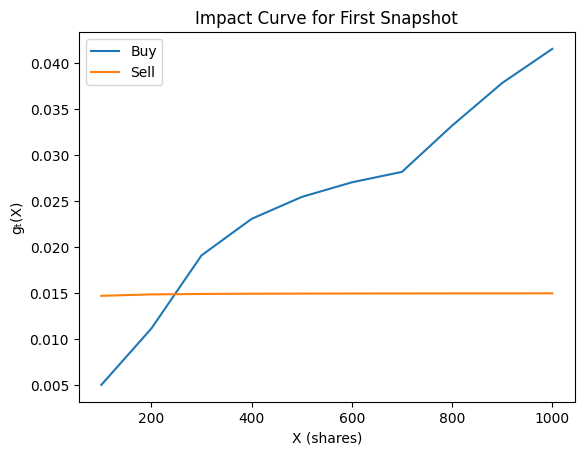

In [16]:
import zipfile
import os
import glob
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import cvxpy as cp
import matplotlib.pyplot as plt

# 1. ZIP archives
zip_files = [
    'SOUN.zip',
    'CRWV.zip',
    'FROG.zip',
]

# 2. Unzip each
extract_dir = '/mnt/data/data_extracted'
os.makedirs(extract_dir, exist_ok=True)
for zip_path in zip_files:
    symbol = os.path.splitext(os.path.basename(zip_path))[0]
    dest = os.path.join(extract_dir, symbol)
    os.makedirs(dest, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(dest)

# 3. Load each CSV into a pandas DataFrame
data = {}
for symbol in ['SOUN', 'CRWV', 'FROG']:
    folder = os.path.join(extract_dir, symbol)
    csv_file = glob.glob(f"{folder}/*.csv")[0]
    df = pd.read_csv(csv_file, low_memory=False)
    # Clean & compute mid‐price
    df = df.dropna(subset=['bid_px_00', 'ask_px_00'])
    df['mid'] = (df['bid_px_00'] + df['ask_px_00']) / 2
    data[symbol] = df

# 4. Define the temporary‐impact function
def temporary_impact(row, side, X):
    """
    row: one book snapshot (pd.Series)
    side='ask' for buy side, 'bid' for sell side
    X: shares to execute
    """
    mid = row['mid']
    prices = [row[f"{side}_px_{i:02d}"] for i in range(10)]
    sizes  = [row[f"{side}_sz_{i:02d}"] for i in range(10)]
    diffs  = [(p-mid) if side=='ask' else (mid-p) for p in prices]
    executed, impact = 0.0, 0.0
    for diff, sz in zip(diffs, sizes):
        if executed >= X:
            break
        take = min(sz, X - executed)
        impact += diff * take
        executed += take
    return impact / X if X > 0 else np.nan

# 5. Compute g_t(X) for the full DataFrame of each symbol
X_grid = list(range(100, 1100, 100))
records = []
snapshot_id = 0

for symbol, df in data.items():
    print(f"Processing {symbol} ({len(df)} rows)...")
    for _, row in df.iterrows():   # iterate full DataFrame
        snapshot_id += 1
        for side, book in [('buy','ask'), ('sell','bid')]:
            for X in X_grid:
                g = temporary_impact(row, book, X)
                records.append({
                    'symbol':      symbol,
                    'snapshot_id': snapshot_id,
                    'side':        side,
                    'X':           X,
                    'g':           g
                })

g_df_full = pd.DataFrame(records)
print("Total temporary impact records:", len(g_df_full))

# 6. Fit linear model g ≈ β·X (buy side) for first 10 snapshots of each symbol
params = []
for symbol in data.keys():
    snaps = sorted(g_df_full[g_df_full.symbol==symbol].snapshot_id.unique())[:10]
    for sid in snaps:
        sub = g_df_full[(g_df_full.symbol==symbol) & (g_df_full.snapshot_id==sid) & (g_df_full.side=='buy')]
        X = sub.X.values.reshape(-1,1)
        Y = sub.g.values
        if len(Y) < 2:
            continue
        lr = LinearRegression(fit_intercept=False).fit(X, Y)
        params.append({
            'symbol':      symbol,
            'snapshot_id': sid,
            'beta_lin':    lr.coef_[0]
        })

params_df = pd.DataFrame(params)
print("Fitted linear impact coefficients (first 10 snapshots):")
print(params_df)

# 7. Example optimization using SOUN's first 5 betas
soun_betas = params_df[params_df.symbol=='SOUN'].beta_lin.values[:5]
N, S = len(soun_betas), 1000
x = cp.Variable(N, nonneg=True)
prob = cp.Problem(cp.Minimize(soun_betas @ x), [cp.sum(x) == S])
prob.solve()
print("Optimal execution schedule for SOUN (5 periods):", x.value)

# 8. (Optional) Plot the first snapshot’s impact curve for verification
first_snap = g_df_full[g_df_full.snapshot_id == params_df.snapshot_id.iloc[0]]
plt.plot(first_snap[first_snap.side=='buy'].X, first_snap[first_snap.side=='buy'].g, label='Buy')
plt.plot(first_snap[first_snap.side=='sell'].X, first_snap[first_snap.side=='sell'].g, label='Sell')
plt.xlabel('X (shares)')
plt.ylabel('gₜ(X)')
plt.title('Impact Curve for First Snapshot')
plt.legend()
plt.show()
